In [53]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from skimage.color import rgb2gray
from skimage.feature import hog
import joblib
from torchvision import transforms



In [2]:
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((label, (xmin, ymin, xmax, ymax)))
    return annotations


In [3]:
def load_image_and_annotations(filename):
    """Loads image and its corresponding annotations by filename (no extension)."""
    img_path = os.path.join(IMG_DIR, filename + '.jpg')
    xml_path = os.path.join(XML_DIR, filename + '.xml')
    image = Image.open(img_path)
    annotations = read_annotations(xml_path)
    return image, annotations

def draw_annotations(image, annotations):
    """Draws bounding boxes and labels on a copy of the input image."""
    annotated = image.copy()
    draw = ImageDraw.Draw(annotated)
    for label, (xmin, ymin, xmax, ymax) in annotations:
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
        draw.text((xmin, ymin), label, fill='red')
    return annotated


In [4]:
DATA_DIR = '/Users/avilochab/Desktop/Grad_School/CSE 802/project/archive/'

IMG_DIR = os.path.join(DATA_DIR, 'JPEGImages')
XML_DIR = os.path.join(DATA_DIR, 'Annotations', 'Horizontal Bounding Boxes')
TRAIN_LIST_PATH = os.path.join(DATA_DIR, 'ImageSets', 'Main', 'train.txt')


In [5]:

with open(TRAIN_LIST_PATH, 'r') as f:
    train_filenames = f.read().splitlines()

sample_file = random.choice(train_filenames)

img, annots = load_image_and_annotations(sample_file)

img_annot = draw_annotations(img, annots)


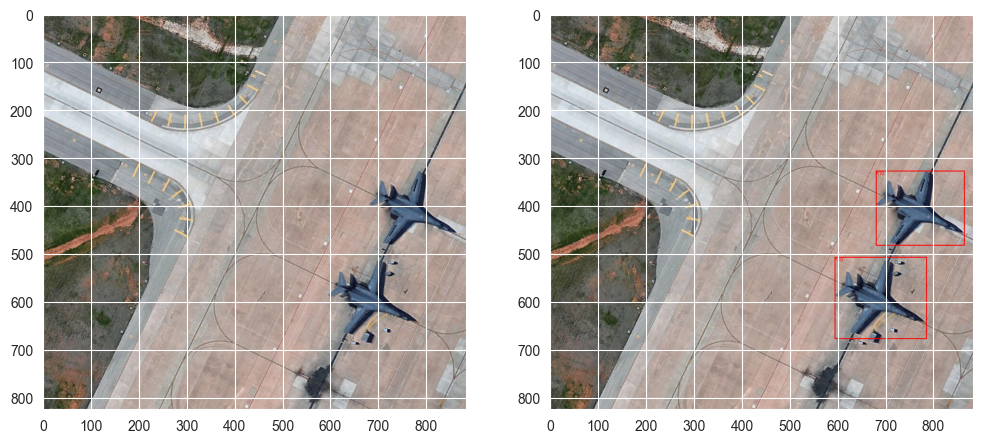

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_annot)


In [10]:
def extract_cropped_objects(filenames, target_size=(128, 128)):
    X = []
    y = []

    for filename in filenames:
        try:
            image, annotations = load_image_and_annotations(filename)
            for label, (xmin, ymin, xmax, ymax) in annotations:
                cropped = image.crop((xmin, ymin, xmax, ymax)).convert("RGB")
                resized = cropped.resize(target_size)
                X.append(np.array(resized))
                y.append(label)


        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    return np.array(X), np.array(y)


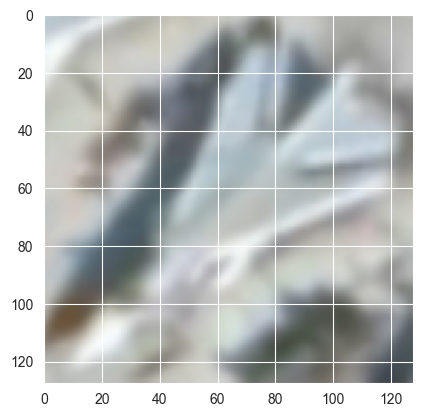

In [11]:
X_crops, y_labels = extract_cropped_objects(train_filenames[:1])
plt.imshow(X_crops[12])
plt.show()


In [ ]:
X_all, y_all = extract_cropped_objects(train_filenames)

In [24]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        gray = rgb2gray(img)
        features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

In [30]:
n_trials = 5
accuracies = []
error_rates = []

for trial in range(n_trials):
    print(f"\n🎯 Trial {trial+1}/{n_trials}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=trial
    )

    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=trial)
    rf.fit(X_train_hog, y_train)

    y_pred = rf.predict(X_test_hog)
    acc = accuracy_score(y_test, y_pred)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Accuracy: {acc * 100:.2f}% | ❌ Error Rate: {err * 100:.2f}%")


print("\n📊 Final Accuracy Summary (Random Forest + HOG):")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Standard Deviation: {np.std(accuracies) * 100:.2f}%")
print(f"Empirical Error Rate: {np.mean(error_rates) * 100:.2f}% ± {np.std(error_rates) * 100:.2f}%")

joblib.dump(rf, "random_forest_hog_model.pkl")


🎯 Trial 1/5
✅ Accuracy: 64.74% | ❌ Error Rate: 35.26%

🎯 Trial 2/5
✅ Accuracy: 65.44% | ❌ Error Rate: 34.56%

🎯 Trial 3/5
✅ Accuracy: 63.53% | ❌ Error Rate: 36.47%

🎯 Trial 4/5
✅ Accuracy: 64.87% | ❌ Error Rate: 35.13%

🎯 Trial 5/5
✅ Accuracy: 65.12% | ❌ Error Rate: 34.88%

📊 Final Accuracy Summary (Random Forest + HOG):
Mean Accuracy: 64.74%
Standard Deviation: 0.65%
Empirical Error Rate: 35.26% ± 0.65%


['random_forest_hog_model.pkl']

In [31]:
#Hog with 100 PCA components

n_trials = 5
accuracies = []
error_rates = []

pca_components = 100

for trial in range(n_trials):
    print(f"\n🌀 Trial {trial+1}/{n_trials}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=trial
    )

    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    pca = PCA(n_components=pca_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_hog)
    X_test_pca = pca.transform(X_test_hog)

    rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=trial)
    rf.fit(X_train_pca, y_train)

    y_pred = rf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Accuracy: {acc * 100:.2f}% | ❌ Error Rate: {err * 100:.2f}%")

print("\n📊 Final Accuracy Summary (HOG + 100 PCA Components + RF):")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Standard Deviation: {np.std(accuracies) * 100:.2f}%")
print(f"Empirical Error Rate: {np.mean(error_rates) * 100:.2f}% ± {np.std(error_rates) * 100:.2f}%")

joblib.dump(rf, "random_forest_hog_100_pca_model.pkl")


🌀 Trial 1/5
✅ Accuracy: 80.24% | ❌ Error Rate: 19.76%

🌀 Trial 2/5
✅ Accuracy: 81.77% | ❌ Error Rate: 18.23%

🌀 Trial 3/5
✅ Accuracy: 80.30% | ❌ Error Rate: 19.70%

🌀 Trial 4/5
✅ Accuracy: 80.69% | ❌ Error Rate: 19.31%

🌀 Trial 5/5
✅ Accuracy: 80.88% | ❌ Error Rate: 19.12%

📊 Final Accuracy Summary (HOG + PCA + RF):
Mean Accuracy: 80.78%
Standard Deviation: 0.55%
Empirical Error Rate: 19.22% ± 0.55%


['random_forest_hog_100_pca_model.pkl']

In [29]:
#Hog with 250 PCA components

n_trials = 5
accuracies = []
error_rates = []

pca_components = 250

for trial in range(n_trials):
    print(f"\n🌀 Trial {trial+1}/{n_trials}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=trial
    )

    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    pca = PCA(n_components=pca_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_hog)
    X_test_pca = pca.transform(X_test_hog)

    rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=trial)
    rf.fit(X_train_pca, y_train)

    y_pred = rf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Accuracy: {acc * 100:.2f}% | ❌ Error Rate: {err * 100:.2f}%")

print("\n📊 Final Accuracy Summary (HOG + 250 PCA Components + RF):")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Standard Deviation: {np.std(accuracies) * 100:.2f}%")
print(f"Empirical Error Rate: {np.mean(error_rates) * 100:.2f}% ± {np.std(error_rates) * 100:.2f}%")

joblib.dump(rf, "random_forest_hog_250_pca_model.pkl")


🌀 Trial 1/5
✅ Accuracy: 73.25% | ❌ Error Rate: 26.75%

🌀 Trial 2/5
✅ Accuracy: 77.38% | ❌ Error Rate: 22.62%

🌀 Trial 3/5
✅ Accuracy: 73.89% | ❌ Error Rate: 26.11%

🌀 Trial 4/5
✅ Accuracy: 75.41% | ❌ Error Rate: 24.59%

🌀 Trial 5/5
✅ Accuracy: 75.35% | ❌ Error Rate: 24.65%

📊 Final Accuracy Summary (HOG + 250 PCA Components + RF):
Mean Accuracy: 75.06%
Standard Deviation: 1.43%
Empirical Error Rate: 24.94% ± 1.43%


['random_forest_hog_250_pca_model.pkl']

In [28]:
#Hog with 50 PCA components

n_trials = 5
accuracies = []
error_rates = []

pca_components = 50

for trial in range(n_trials):
    print(f"\n🌀 Trial {trial+1}/{n_trials}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=trial
    )

    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    pca = PCA(n_components=pca_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_hog)
    X_test_pca = pca.transform(X_test_hog)

    rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=trial)
    rf.fit(X_train_pca, y_train)

    y_pred = rf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    err = 1 - acc
    accuracies.append(acc)
    error_rates.append(err)

    print(f"✅ Accuracy: {acc * 100:.2f}% | ❌ Error Rate: {err * 100:.2f}%")


print("\n📊 Final Accuracy Summary (HOG + 50 PCA Components + RF):")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Standard Deviation: {np.std(accuracies) * 100:.2f}%")
print(f"Empirical Error Rate: {np.mean(error_rates) * 100:.2f}% ± {np.std(error_rates) * 100:.2f}%")

joblib.dump(rf, "random_forest_hog_50_pca_model.pkl")


🌀 Trial 1/5
✅ Accuracy: 81.51% | ❌ Error Rate: 18.49%

🌀 Trial 2/5
✅ Accuracy: 83.48% | ❌ Error Rate: 16.52%

🌀 Trial 3/5
✅ Accuracy: 80.69% | ❌ Error Rate: 19.31%

🌀 Trial 4/5
✅ Accuracy: 82.53% | ❌ Error Rate: 17.47%

🌀 Trial 5/5
✅ Accuracy: 81.96% | ❌ Error Rate: 18.04%

📊 Final Accuracy Summary (HOG + 50 PCA Components + RF):
Mean Accuracy: 82.03%
Standard Deviation: 0.94%
Empirical Error Rate: 17.97% ± 0.94%


['random_forest_hog_50_pca_model.pkl']

In [32]:
#Effects of Camo and other Environmental factors


🌦 Evaluating under: Camouflage / Low Contrast
✅ Accuracy under Camouflage / Low Contrast: 95.93%


/var/folders/4l/64216gh929b1_yptg401h4880000gn/T/ipykernel_53296/1466536923.py:45: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Arial.
  plt.tight_layout()
/Users/avilochab/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


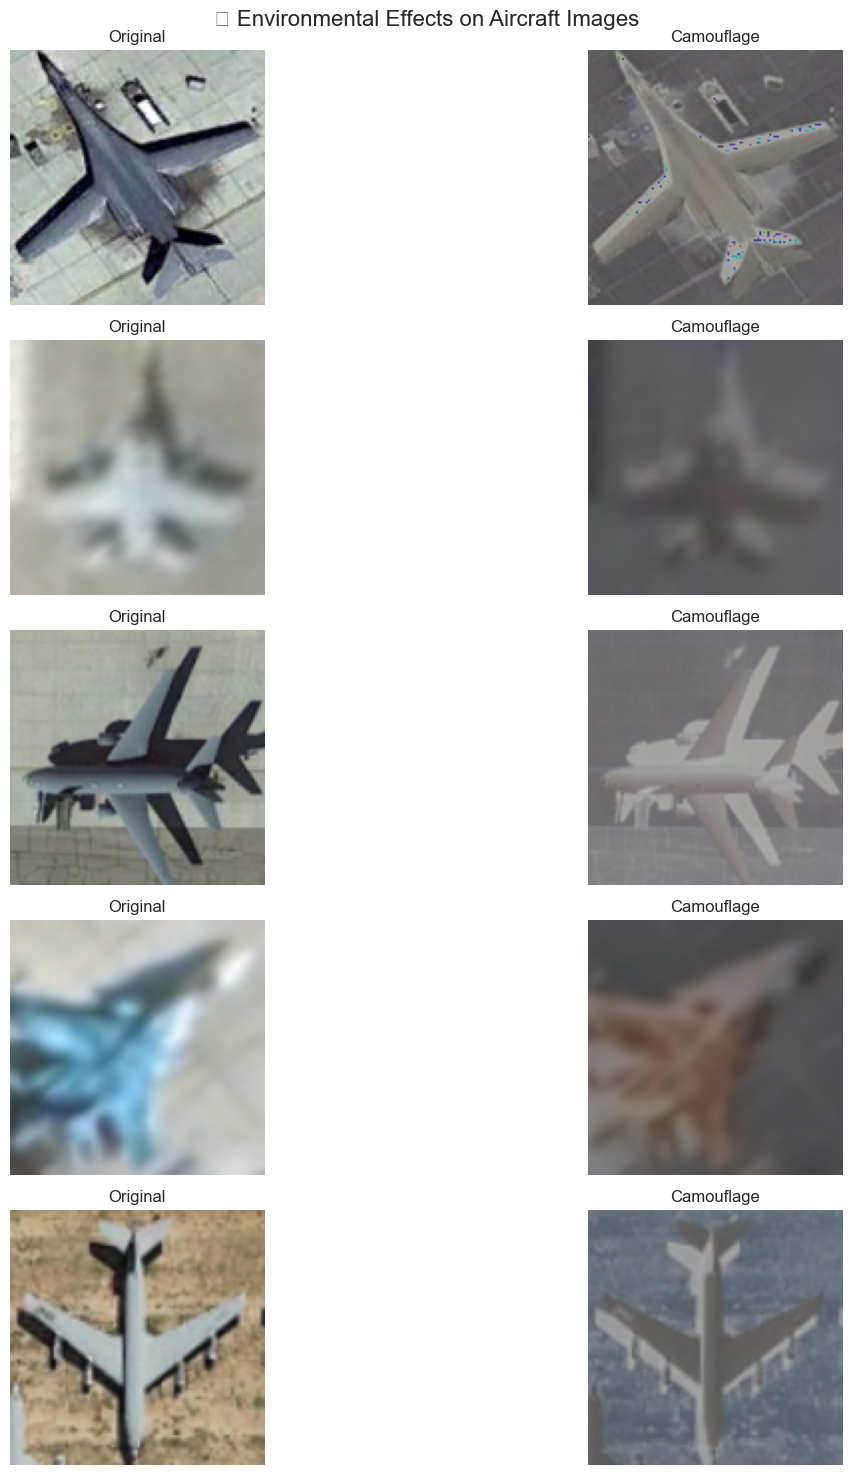

In [57]:
def simulate_lighting_variation(img):
    transform = transforms.ColorJitter(brightness=0.6, contrast=0.2)
    return transform(img)

def simulate_camouflage(img):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(0.4)  # Lower contrast

def apply_environmental_effects(X_test_np, effect_fn):
    augmented = []
    for img in X_test_np:
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        aug_img = effect_fn(pil_img)
        aug_arr = np.array(aug_img) / 255.0
        aug_arr = np.transpose(aug_arr, (2, 0, 1))
        augmented.append(aug_arr)
    return np.array(augmented)



def show_augmented_samples(X, effects_dict, n=5):
    idxs = random.sample(range(len(X)), n)

    fig, axs = plt.subplots(n, len(effects_dict) + 1, figsize=(15, 3 * n))
    fig.suptitle("📸 Environmental Effects on Aircraft Images", fontsize=16)

    for row, i in enumerate(idxs):
        original = X[i]
        if original.shape[0] == 3:
            original = np.transpose(original, (1, 2, 0))

        axs[row][0].imshow(original)
        axs[row][0].axis('off')
        axs[row][0].set_title("Original")

        for col, (name, fn) in enumerate(effects_dict.items(), start=1):
            pil_img = Image.fromarray((original * 255).astype(np.uint8))
            aug_img = fn(pil_img)
            axs[row][col].imshow(aug_img)
            axs[row][col].axis('off')
            axs[row][col].set_title(name)

    plt.tight_layout()
    plt.show()


def evaluate_under_condition(X, y, effect_fn, name):
    print(f"\n🌦 Evaluating under: {name}")
    X_aug = apply_environmental_effects(X, effect_fn)
    X_hog = extract_hog_features(X_aug)
    X_pca = pca.transform(X_hog)
    y_pred = rf.predict(X_pca)
    acc = accuracy_score(y, y_pred)
    print(f"✅ Accuracy under {name}: {acc * 100:.2f}%")

X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all
    )

evaluate_under_condition(X_test, y_test, simulate_camouflage, "Camouflage / Low Contrast")
show_augmented_samples(X_test, effects_dict={"Camouflage": simulate_camouflage}, n=5)



🌦 Evaluating under: Lighting Variation
✅ Accuracy under Lighting Variation: 95.24%


/var/folders/4l/64216gh929b1_yptg401h4880000gn/T/ipykernel_53296/3246320154.py:45: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Arial.
  plt.tight_layout()
/Users/avilochab/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


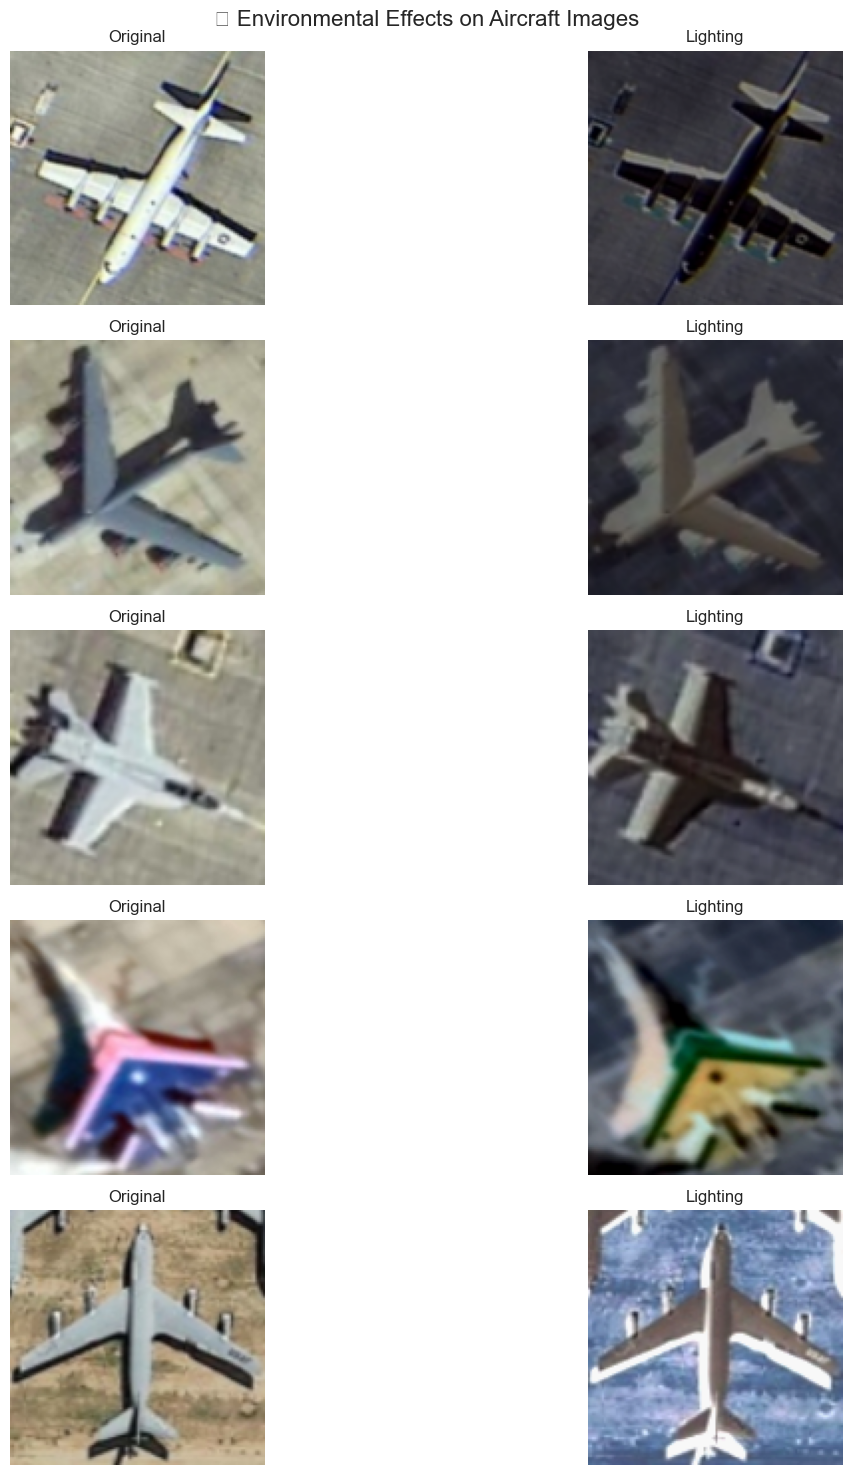

In [56]:
evaluate_under_condition(X_test, y_test, simulate_lighting_variation, "Lighting Variation")
show_augmented_samples(X_test, effects_dict={"Lighting": simulate_lighting_variation}, n=5)

In [58]:
#Effect of model trained on camo images but tested on normal images

In [69]:
accuracies = []
pca_components = 50
n_runs = 5

for run in range(n_runs):
    print(f"\n🔁 Run {run+1}/{n_runs}")

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=run)

    X_train_camouflaged = apply_environmental_effects(X_train, simulate_camouflage)

    X_train_hog = extract_hog_features(X_train_camouflaged)
    X_test_hog = extract_hog_features(X_test)

    pca = PCA(n_components=pca_components)
    X_train_pca = pca.fit_transform(X_train_hog)
    X_test_pca = pca.transform(X_test_hog)

    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 Accuracy: {acc * 100:.2f}%")
    accuracies.append(acc)

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"\n📊 Final Results over {n_runs} runs:")
print(f"✅ Mean Accuracy: {mean_acc * 100:.2f}%")
print(f"📉 Std Deviation: {std_acc * 100:.2f}%")


🔁 Run 1/5
🎯 Accuracy: 78.97%

🔁 Run 2/5
🎯 Accuracy: 78.14%

🔁 Run 3/5
🎯 Accuracy: 79.67%

🔁 Run 4/5
🎯 Accuracy: 81.45%

🔁 Run 5/5
🎯 Accuracy: 79.42%

📊 Final Results over 5 runs:
✅ Mean Accuracy: 79.53%
📉 Std Deviation: 1.09%


In [70]:
#Model Stability and Performance


🔄 Evaluating with Test Size: 10%

📂 Run 1/5 — Random Split
🎯 Test Accuracy: 82.59%

📂 Run 2/5 — Random Split
🎯 Test Accuracy: 82.97%

📂 Run 3/5 — Random Split
🎯 Test Accuracy: 82.47%

📂 Run 4/5 — Random Split
🎯 Test Accuracy: 83.35%

📂 Run 5/5 — Random Split
🎯 Test Accuracy: 83.48%

📊 Summary:
✅ Mean Test Accuracy for Test Size 10%: 82.97%
📉 Std Deviation: 0.40%

🔄 Evaluating with Test Size: 20%

📂 Run 1/5 — Random Split
🎯 Test Accuracy: 82.21%

📂 Run 2/5 — Random Split
🎯 Test Accuracy: 82.15%

📂 Run 3/5 — Random Split
🎯 Test Accuracy: 80.81%

📂 Run 4/5 — Random Split
🎯 Test Accuracy: 82.53%

📂 Run 5/5 — Random Split
🎯 Test Accuracy: 81.19%

📊 Summary:
✅ Mean Test Accuracy for Test Size 20%: 81.78%
📉 Std Deviation: 0.66%

🔄 Evaluating with Test Size: 30%

📂 Run 1/5 — Random Split
🎯 Test Accuracy: 78.83%

📂 Run 2/5 — Random Split
🎯 Test Accuracy: 79.85%

📂 Run 3/5 — Random Split
🎯 Test Accuracy: 81.54%

📂 Run 4/5 — Random Split
🎯 Test Accuracy: 79.89%

📂 Run 5/5 — Random Split
🎯 Test A

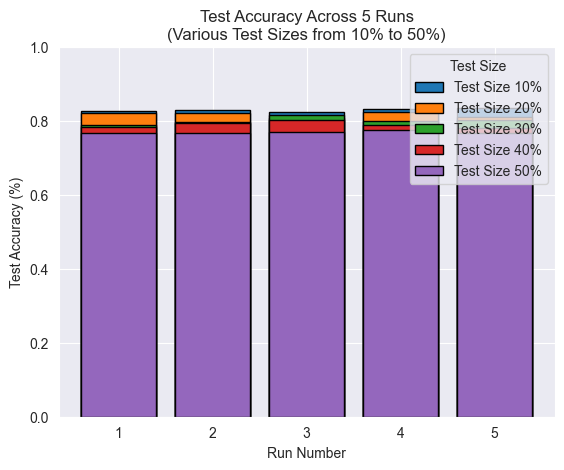

In [75]:
pca_components = 50
n_runs = 5
test_sizes = np.arange(0.1, 0.51, 0.1)  # Test sizes from 10% to 50% with a step of 10%

for test_size in test_sizes:
    print(f"\n🔄 Evaluating with Test Size: {int(test_size * 100)}%")

    accuracies = []

    for run in range(n_runs):
        print(f"\n📂 Run {run+1}/{n_runs} — Random Split")

        # Step 1: Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_size, random_state=run)

        # Step 2: Feature Extraction (NO CAMOUFLAGE)
        X_train_hog = extract_hog_features(X_train)
        X_test_hog = extract_hog_features(X_test)

        # Step 3: PCA
        pca = PCA(n_components=pca_components)
        X_train_pca = pca.fit_transform(X_train_hog)
        X_test_pca = pca.transform(X_test_hog)

        # Step 4: Train Classifier
        clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
        clf.fit(X_train_pca, y_train)

        # Step 5: Test Accuracy
        test_pred = clf.predict(X_test_pca)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"🎯 Test Accuracy: {test_acc * 100:.2f}%")

        accuracies.append(test_acc)

    # Store results for each test size
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    print("\n📊 Summary:")
    print(f"✅ Mean Test Accuracy for Test Size {int(test_size * 100)}%: {mean_acc * 100:.2f}%")
    print(f"📉 Std Deviation: {std_acc * 100:.2f}%")